In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
df1=pd.read_csv('C:\\Users\\asus\\Desktop\\US_Accidents_Dec20_Updated.csv')
df = df1.loc[:,['ID','Start_Time']]
def year(string):
    return int(string[0:4])
df['Year']=df['Start_Time'].apply(lambda x: year(x))
#creating month column
def month(string):
    return int(string[5:7])
df['Month']=df['Start_Time'].apply(lambda x: month(x))
#creating day column
def day(string):
    return int(string[8:10])
df['Day']=df['Start_Time'].apply(lambda x: day(x))
dft1 = df.copy() #把原先的数据copy一份，在副本中操作
dft1['date'] = pd.to_datetime(df[['Year',  'Month','Day']])
dft1['date']=pd.to_datetime(dft1['date'])
dft2 = dft1.groupby('date' , as_index = False).count()
dft2.index = pd.DatetimeIndex(dft2['date'])
dft2.drop(['Start_Time'] , axis = 1 ,inplace = True)
dft2.drop(['Year'] , axis = 1 ,inplace = True)
dft2.drop(['Month'] , axis = 1 ,inplace = True)
dft2.drop(['Day'] , axis = 1 ,inplace = True)
dft2.drop(['date'] , axis = 1 ,inplace = True)
print(dft2)

C:\Users\asus\anaconda3\envs\test\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (30,31,32,33,34,35,36,37,38,39,40,41,42) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


              ID
date            
2016-02-08     4
2016-02-09     5
2016-02-10     7
2016-02-11     6
2016-02-12     2
...          ...
2020-12-27   583
2020-12-28  1029
2020-12-29   983
2020-12-30  1121
2020-12-31   859

[1778 rows x 1 columns]


In [3]:
dft2=dft2[:1460]

In [6]:
ts1=dft2
#构造训练集与验证集
# 时间点长度
time_stamp = 7
# 划分训练集与验证集
train = ts1[0:1095 + time_stamp]
valid = ts1[1095 - time_stamp:]
# 归一化
scaler = MinMaxScaler(feature_range=(0, 1))  
scaled_data = scaler.fit_transform(train)
x_train, y_train = [], []
# 训练集
for i in range(time_stamp, len(train)-7):
    x_train.append(scaled_data[i - time_stamp:i])
    y_train.append(scaled_data[i: i+7])
x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)
print(y_train.shape)
# 验证集
scaled_data = scaler.fit_transform(valid)
x_valid, y_valid = [], []
print(valid)
for i in range(time_stamp, len(valid)):
    x_valid.append(scaled_data[i - time_stamp:i])
    if(i<len(valid)-7):
        y_valid.append(scaled_data[i:i+ 7])
x_valid, y_valid = np.array(x_valid), np.array(y_valid)
print(x_valid.shape)
print(y_valid.shape)

(1088, 7, 1)
(1088, 7, 1)
             ID
date           
2019-02-10  100
2019-02-11  232
2019-02-12  292
2019-02-13  235
2019-02-14  277
...         ...
2020-02-12  305
2020-02-13  351
2020-02-14  341
2020-02-15  174
2020-02-16  123

[372 rows x 1 columns]
(365, 7, 1)
(358, 7, 1)


In [10]:
from keras.models import Sequential
from keras.layers.core import Dense,Dropout
from keras.optimizers import SGD
#创建并训练模型
# 超参数
epochs = 3
batch_size = 1
model = Sequential()

model.add(Dense(32,activation='relu' ,input_shape=(x_train.shape[1],x_train.shape[2] )))
model.add(Dense(64,activation='relu'))
#将模型封装好，使用均方误差作为损失函数
model.add(Dense(1))
model.compile(loss='mse', optimizer=SGD(lr=0.001),metrics=['mae'])
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/3
1088/1088 [==============================] - 12s 771us/step - loss: 0.1334 - mae: 0.2925
Epoch 2/3
1088/1088 [==============================] - 1s 841us/step - loss: 0.0319 - mae: 0.1566
Epoch 3/3
1088/1088 [==============================] - 1s 732us/step - loss: 0.0242 - mae: 0.1316


In [14]:
closing_price.shape

(365, 7)

In [13]:
import warnings
warnings.filterwarnings("ignore")
closing_price = model.predict(x_valid)
closing_price=np.reshape(closing_price, (closing_price.shape[0], 7))
# 反归一化
closing_price = scaler.inverse_transform(closing_price)
predict=[]  
for i in range(len(closing_price)):
    predict.append(closing_price[i][0])
for i in range(7):
    predict.append(closing_price[364][i])
from sklearn import metrics
from sklearn.metrics import r2_score#R square
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100
# MSE
print('MSE:%.4f'%metrics.mean_squared_error(predict[7:],ts1[1095 :])) 
# RMSE
print('RMSE:%.4f'%np.sqrt(metrics.mean_squared_error(predict[7:],ts1[1095 :]))) 
# MAE;
print('MAE:%.4f'%metrics.mean_absolute_error(predict[7:],ts1[1095 :])) 
# MAPE
print('MAPE:%.4f'%mape(predict[7:],ts1[1095 :].values))
# SMAPE
print('SMAPE:%.4f'%smape(predict[7:],ts1[1095 :].values))
print('R2_SCORE:%.4f'%r2_score(ts1[1095 :].values,predict[7:]))

MSE:1576.8994
RMSE:39.7102
MAE:31.7755
MAPE:43.8006
SMAPE:44.2208
R2_SCORE:0.8177


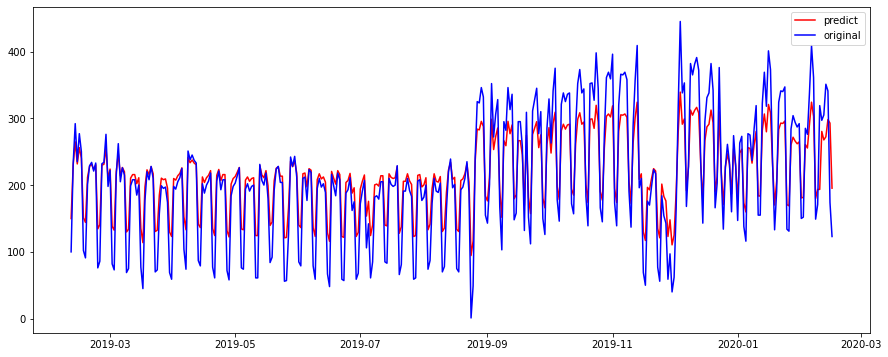

                     0
date                  
2019-02-17  144.071442
2019-02-18  211.587784
2019-02-19  228.131638
2019-02-20  231.085892
2019-02-21  223.404816
...                ...
2020-02-12  267.645966
2020-02-13  272.274628
2020-02-14  298.078796
2020-02-15  292.794861
2020-02-16  195.352570

[365 rows x 1 columns]


In [17]:
from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize']=15,6
predict=pd.DataFrame(predict)
from datetime import datetime
predict.index=valid.index
plt.plot(predict,color='red',label='predict')
plt.plot(ts1[1095-7 :],color='blue',label='original')
plt.legend(loc='best')
plt.show()
print(predict[7:])